# 2. Predictive Analytics on customer transaction data

Tasks need to be done: 

 - Using the same transaction dataset, identify the annual salary for each customer

 - Explore correlations between annual salary and various customer attributes (e.g. age). These attributes could be those that are readily available in the data (e.g. age) or those that you construct or derive yourself (e.g. those relating to purchasing behaviour). Visualise any interesting correlations using a scatter plot.

 - Build a simple regression model to predict the annual salary for each customer using the attributes you identified above

 - How accurate is your model? Should ANZ use it to segment customers (for whom it does not have this data) into income brackets for reporting purposes?

For a challenge: build a decision-tree based model to predict salary. Does it perform better? How would you accurately test the performance of this model?

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('dark')

import matplotlib.pyplot as plt
%matplotlib inline

import datetime

In [2]:
data = pd.read_excel('ANZ synthesised transaction dataset.xlsx')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   status             12043 non-null  object        
 1   card_present_flag  7717 non-null   float64       
 2   bpay_biller_code   885 non-null    object        
 3   account            12043 non-null  object        
 4   currency           12043 non-null  object        
 5   long_lat           12043 non-null  object        
 6   txn_description    12043 non-null  object        
 7   merchant_id        7717 non-null   object        
 8   merchant_code      883 non-null    float64       
 9   first_name         12043 non-null  object        
 10  balance            12043 non-null  float64       
 11  date               12043 non-null  datetime64[ns]
 12  gender             12043 non-null  object        
 13  age                12043 non-null  int64         
 14  mercha

In [4]:
data.nunique()

status                   2
card_present_flag        2
bpay_biller_code         3
account                100
currency                 1
long_lat               100
txn_description          6
merchant_id           5725
merchant_code            1
first_name              80
balance              12006
date                    91
gender                   2
age                     33
merchant_suburb       1609
merchant_state           8
extraction            9442
amount                4457
transaction_id       12043
country                  1
customer_id            100
merchant_long_lat     2703
movement                 2
dtype: int64

In [5]:
df = data[['status','account', 'customer_id', 'long_lat','txn_description','first_name','date','gender','age','extraction','amount','balance','movement', 'merchant_id', 'merchant_suburb','merchant_long_lat']]
df.head()

,status,account,customer_id,long_lat,txn_description,first_name,date,gender,age,extraction,amount,balance,movement,merchant_id,merchant_suburb,merchant_long_lat
0,authorized,ACC-1598451071,CUS-2487424745,153.41 -27.95,POS,Diana,2018-08-01,F,26,2018-08-01T01:01:15.000+0000,16.25,35.39,debit,81c48296-73be-44a7-befa-d053f48ce7cd,Ashmore,153.38 -27.99
1,authorized,ACC-1598451071,CUS-2487424745,153.41 -27.95,SALES-POS,Diana,2018-08-01,F,26,2018-08-01T01:13:45.000+0000,14.19,21.20,debit,830a451c-316e-4a6a-bf25-e37caedca49e,Sydney,151.21 -33.87
2,authorized,ACC-1222300524,CUS-2142601169,151.23 -33.94,POS,Michael,2018-08-01,M,38,2018-08-01T01:26:15.000+0000,6.42,5.71,debit,835c231d-8cdf-4e96-859d-e9d571760cf0,Sydney,151.21 -33.87
3,authorized,ACC-1037050564,CUS-1614226872,153.10 -27.66,SALES-POS,Rhonda,2018-08-01,F,40,2018-08-01T01:38:45.000+0000,40.90,2117.22,debit,48514682-c78a-4a88-b0da-2d6302e64673,Buderim,153.05 -26.68
4,authorized,ACC-1598451071,CUS-2487424745,153.41 -27.95,SALES-POS,Diana,2018-08-01,F,26,2018-08-01T01:51:15.000+0000,3.25,17.95,debit,b4e02c10-0852-4273-b8fd-7b3395e32eb0,Mermaid Beach,153.44 -28.06


In [6]:
df.groupby(['customer_id','txn_description']).mean().reset_index()['txn_description'].value_counts()

PAY/SALARY    100
PAYMENT       100
POS           100
SALES-POS      99
INTER BANK     68
PHONE BANK     16
Name: txn_description, dtype: int64

### Calculate Annual Salary of Customers

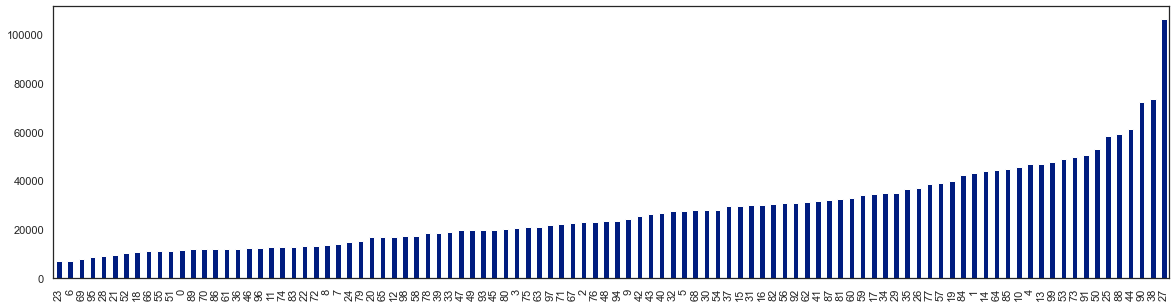

In [7]:
df_salary_after_tax = df.loc[df['movement']=='credit'].groupby(['customer_id']).agg({'amount': 'mean'}).reset_index()
df_salary_after_tax['amount'] = df_salary_after_tax['amount']*12
df_salary_after_tax.rename(columns={'amount':'annual_salary'},inplace=True)
df_salary_after_tax['annual_salary'].sort_values().plot(kind='bar',figsize=(20,5))

### Explore correlations between salary and other attributes

In [8]:
df_cor = df.loc[df['movement']=='debit'].groupby(['customer_id']).agg({'age':'first','gender':'first','amount': ['mean','max','count'], 'balance':['mean','min']}).reset_index()
df_cor.columns = ["_".join ((i,k)) for i,k in df_cor.columns]
df_cor.rename(columns={'customer_id_': 'customer_id', 'age_first':'age', 'gender_first':'gender'},inplace=True)
df_corr = pd.merge(df_cor,df_salary_after_tax, on='customer_id')
df_corr

,customer_id,age,gender,amount_mean,amount_max,amount_count,balance_mean,balance_min,annual_salary
0,CUS-1005756958,53,F,60.881000,226.82,60,1746.575833,41.40,11645.64
1,CUS-1117979751,21,M,96.062581,2885.85,93,9669.811613,2256.46,42943.80
2,CUS-1140341822,28,M,74.480270,1271.46,74,5687.657568,741.82,22998.12
3,CUS-1147642491,34,F,64.121429,432.92,105,9060.001714,1640.51,20536.68
4,CUS-1196156254,34,F,36.658025,390.67,238,22226.160714,12529.59,46844.76
...,...,...,...,...,...,...,...,...,...
95,CUS-72755508,35,F,59.446304,1180.00,46,4481.613043,973.14,8703.84
96,CUS-809013380,21,F,48.001622,1383.00,111,3543.482342,1470.89,12444.84
97,CUS-860700529,30,M,31.930220,378.76,227,3442.209251,2.85,21703.44
98,CUS-880898248,26,M,39.702361,671.23,72,8429.367917,5562.68,17207.76


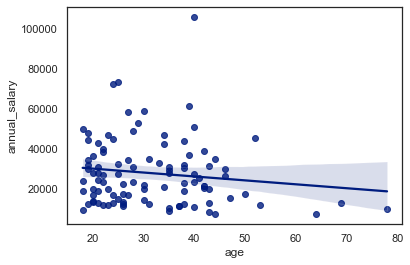

In [9]:
sns.regplot(x='age',y='annual_salary', data=df_corr)

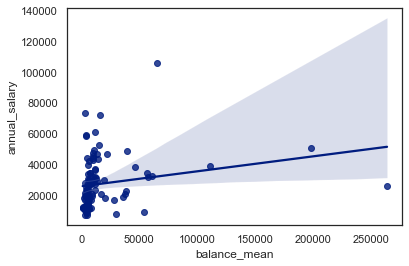

In [10]:
sns.regplot(x='balance_mean',y='annual_salary', data=df_corr)

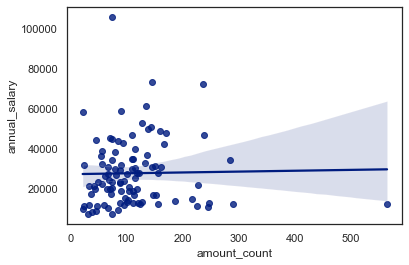

In [11]:
sns.regplot(x='amount_count',y='annual_salary', data=df_corr)

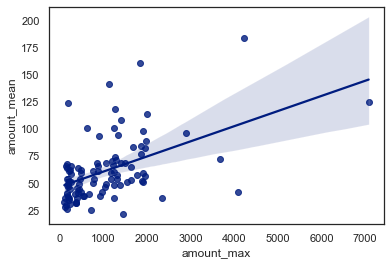

In [12]:
sns.regplot(x='amount_max',y='amount_mean', data=df_corr)

In [13]:
df_payment = df.loc[(df['movement']=='debit') &(df['txn_description'] == 'PAYMENT')].groupby(['customer_id']).agg({'amount': ['mean','count']}).reset_index()
df_pos = df.loc[(df['movement']=='debit') &(df['txn_description'] == 'POS')].groupby(['customer_id']).agg({'amount': ['mean','count']}).reset_index()
df_spos = df.loc[(df['movement']=='debit') &(df['txn_description'] == 'SALES-POS')].groupby(['customer_id']).agg({'amount': ['mean','count']}).reset_index()
df_intbank = df.loc[(df['movement']=='debit') &(df['txn_description'] == 'INTER BANK')].groupby(['customer_id']).agg({'amount': ['mean','count']}).reset_index()
df_phonebank = df.loc[(df['movement']=='debit') &(df['txn_description'] == 'PHONE BANK')].groupby(['customer_id']).agg({'amount': ['mean','count']}).reset_index()


In [14]:
df_payment.columns = ["_".join ((i,k)) for i,k in df_payment.columns]
df_payment.rename(columns={'customer_id_': 'customer_id', 'amount_mean':'payment_mean', 'amount_count':'payment_count'},inplace=True)
df_corr = pd.merge(df_corr,df_payment, on='customer_id')

In [15]:
df_pos.columns = ["_".join ((i,k)) for i,k in df_pos.columns]
df_pos.rename(columns={'customer_id_': 'customer_id', 'amount_mean':'pos_mean', 'amount_count':'pos_count'},inplace=True)
df_corr = pd.merge(df_corr,df_pos, on='customer_id')

In [17]:
df_spos.columns = ["_".join ((i,k)) for i,k in df_spos.columns]
df_spos.rename(columns={'customer_id_': 'customer_id', 'amount_mean':'spos_mean', 'amount_count':'spos_count'},inplace=True)
df_corr = pd.merge(df_corr,df_spos, how='left', on='customer_id')


In [19]:
df_intbank.columns = ["_".join ((i,k)) for i,k in df_intbank.columns]
df_intbank.rename(columns={'customer_id_': 'customer_id', 'amount_mean':'intbank_mean', 'amount_count':'intbank_count'},inplace=True)
df_corr = pd.merge(df_corr,df_intbank, how='left', on='customer_id')

In [20]:
df_phonebank.columns = ["_".join ((i,k)) for i,k in df_phonebank.columns]
df_phonebank.rename(columns={'customer_id_': 'customer_id', 'amount_mean':'phonebank_mean', 'amount_count':'phonebank_count'},inplace=True)
df_corr = pd.merge(df_corr,df_phonebank, how='left', on='customer_id')

In [22]:
df_corr.fillna(0,inplace=True)

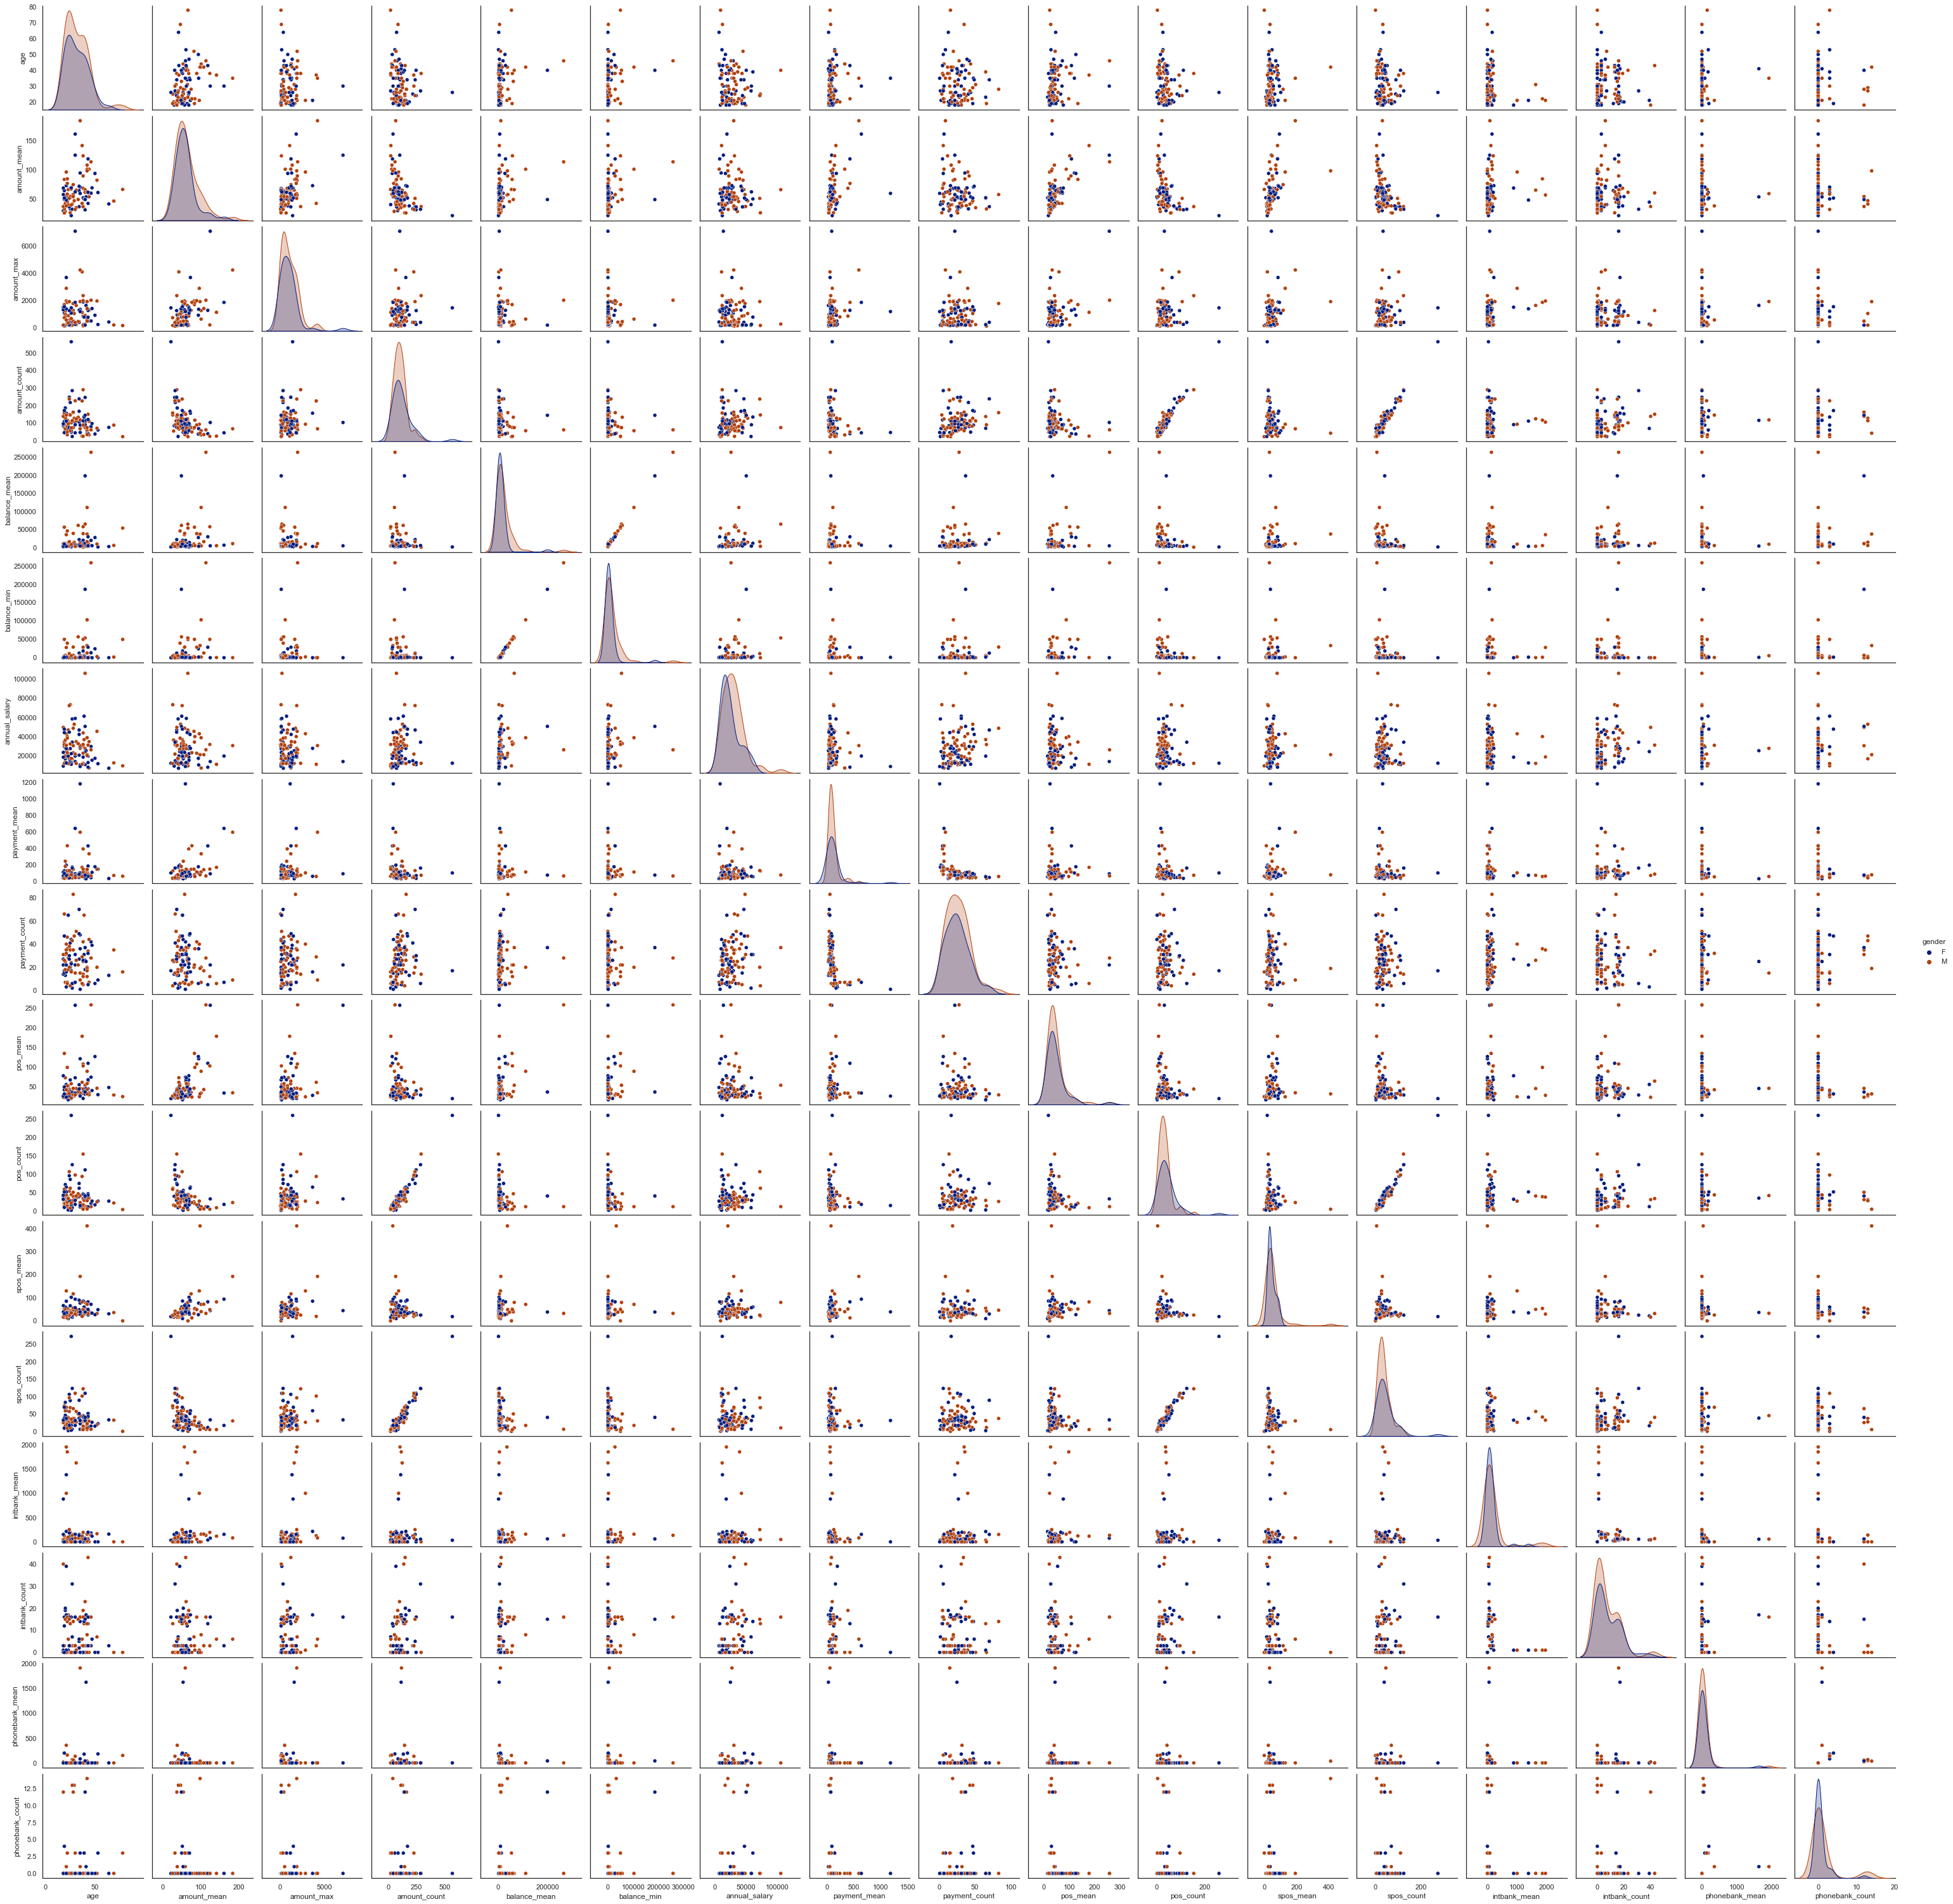

In [23]:
sns.pairplot(df_corr, hue="gender")

### Prediction of salary 

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from scipy.stats import boxcox
from scipy.special import inv_boxcox


lr = LinearRegression()
s = StandardScaler()
le = LabelEncoder()

In [25]:
df_corr.head()

,customer_id,age,gender,amount_mean,amount_max,amount_count,balance_mean,balance_min,annual_salary,payment_mean,payment_count,pos_mean,pos_count,spos_mean,spos_count,intbank_mean,intbank_count,phonebank_mean,phonebank_count
0,CUS-1005756958,53,F,60.881000,226.82,60,1746.575833,41.40,11645.64,144.000000,9,28.769615,26,48.311364,22.0,0.0,0.0,182.0,3.0
1,CUS-1117979751,21,M,96.062581,2885.85,93,9669.811613,2256.46,42943.80,98.925000,40,23.321923,26,129.594231,26.0,1001.0,1.0,0.0,0.0
2,CUS-1140341822,28,M,74.480270,1271.46,74,5687.657568,741.82,22998.12,142.000000,6,34.781282,39,116.656538,26.0,90.0,3.0,0.0,0.0
3,CUS-1147642491,34,F,64.121429,432.92,105,9060.001714,1640.51,20536.68,96.185185,27,54.271316,38,47.985263,38.0,125.0,2.0,0.0,0.0
4,CUS-1196156254,34,F,36.658025,390.67,238,22226.160714,12529.59,46844.76,43.100000,70,31.157432,74,29.606292,89.0,153.4,5.0,0.0,0.0


In [27]:
x = df_corr[['age', 'gender', 'balance_mean','payment_count','payment_mean','pos_count','pos_mean','spos_count','spos_mean', 'intbank_count','intbank_mean','phonebank_count','phonebank_mean']]
y = df_corr['annual_salary']


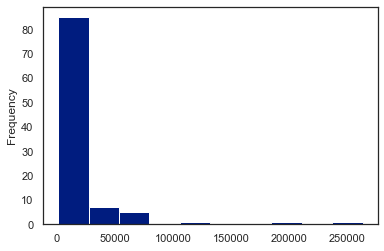

In [28]:
x.balance_mean.plot(kind='hist')

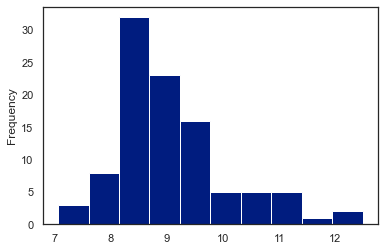

In [29]:
x.balance_mean.apply(lambda x: np.log(x+1)).plot(kind='hist')

In [30]:
x['balance_mean'] = x.balance_mean.apply(lambda x: np.log(x+1))
x['payment_mean'] = x.payment_mean.apply(lambda x: np.log(x+1))
x['pos_mean'] = x.pos_mean.apply(lambda x: np.log(x+1))
x['spos_mean'] = x.pos_mean.apply(lambda x: np.log(x+1))
x['intbank_mean'] = x.pos_mean.apply(lambda x: np.log(x+1))
x['phonebank_mean'] = x.pos_mean.apply(lambda x: np.log(x+1))


d:\miniconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
d:\miniconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
d:\miniconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [31]:
x['gender'] = le.fit_transform(x['gender'])


d:\miniconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
x.head()

,age,gender,balance_mean,payment_count,payment_mean,pos_count,pos_mean,spos_count,spos_mean,intbank_count,intbank_mean,phonebank_count,phonebank_mean
0,53,0,7.465985,9,4.976734,26,3.393488,22.0,1.480124,0.0,1.480124,3.0,1.480124
1,21,1,9.176868,40,4.604420,26,3.191378,26.0,1.433030,1.0,1.433030,0.0,1.433030
2,28,1,8.646230,6,4.962845,39,3.577425,26.0,1.521137,3.0,1.521137,0.0,1.521137
3,34,0,9.111735,27,4.576618,38,4.012254,38.0,1.611886,2.0,1.611886,0.0,1.611886
4,34,0,10.009070,70,3.786460,74,3.470644,89.0,1.497532,5.0,1.497532,0.0,1.497532


In [33]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3)

In [34]:
x_train_s = s.fit_transform(x_train)
x_test_s = s.transform(x_test)

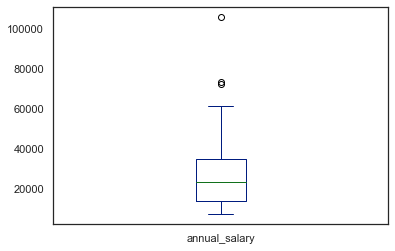

In [35]:
y.plot(kind='box')

In [36]:
bc_result = boxcox(y_train)
y_train_bc = bc_result[0]
lm = bc_result[1]

### Linear Regression

In [37]:
# fit to Linear Regression
lr.fit(x_train_s, y_train_bc)
y_pred_bc = lr.predict(x_test_s)

In [38]:
#inverse box cox to get actual data
y_pred_lr = inv_boxcox(y_pred_bc,lm)

In [39]:
#compare results

r2_score(y_test, y_pred_lr)

0.12683071475041297

In [40]:
mean_squared_error(y_test, y_pred_lr,squared=False)

19777.326019155407

### Decision Tree based predictor

In [41]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(x_train_s, y_train_bc)
y_pred_bc1 = dt.predict(x_test_s)
y_pred_dt = inv_boxcox(y_pred_bc1,lm)


In [42]:
r2_score(y_test, y_pred_dt)

0.025232735848904952

In [43]:
mean_squared_error(y_test, y_pred_dt,squared=False)

20896.272127133114

## Model Evaluation

Based on the two models, we can create the following table to summaries the model performance


| Model | R2 Score | MSE |
| ----- | ------ | -----|
|Linear Regression | 0.126|19777.32|
|Decision Tree| 0.025| 20896.27|